In [1]:
# Importing dependencies
import pandas as pd
import os
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [2]:
!pip install tensorflow_addons

In [3]:
#data_path = '/Users/rahuln/PycharmProjects/picardo/carsim_data'
#columns = ['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']

In [4]:
#data = pd.read_csv(os.path.join(data_path, 'driving_log.csv'), names=columns)

In [3]:
data_path = '/Users/rahuln/PycharmProjects/PiCardo/machine-learning-in-science-ii-2023'

In [4]:
columns = ['image_id', 'angle', 'speed']
data = pd.read_csv(os.path.join(data_path, 'training_norm.csv'), delimiter= ',', header=0, names = columns)

In [6]:
data.head()

,image_id,angle,speed
0,1,0.4375,0.0
1,2,0.8125,1.0
2,3,0.4375,1.0
3,4,0.6250,1.0
4,5,0.5000,0.0


In [11]:
# train test split of dataset
def train_test_split(data):
    rng = np.random.RandomState(seed=1234)

    train_data = data.sample(frac=0.7, random_state=rng)
    test_data = data.loc[~data.index.isin(train_data.index)]

    return train_data, test_data

training_data, validation_data = train_test_split(data)

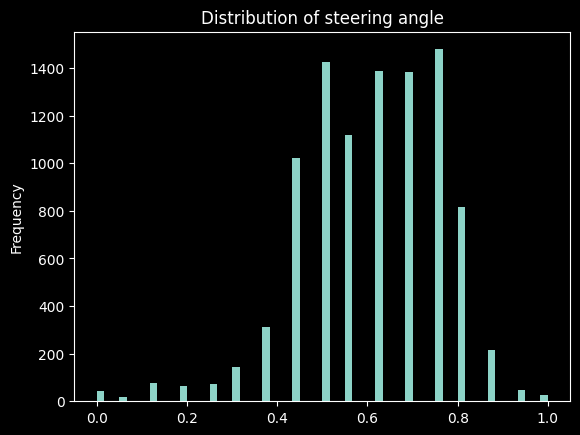

In [14]:
def visualize(data, attr):
    nBins = 60
    plt.hist(data.loc[:,attr], bins=nBins)
    plt.gca().set(title=f'Distribution of steering {attr}', ylabel='Frequency')

visualize(training_data, attr='angle')

In [141]:
# Data-preprocessing
images, angles =  data.loc[:,'image_id'], data.loc[:, 'angle'].tolist()

In [142]:
imagesLst=[]
for img in images:
    imagesLst.append(os.path.join(data_path,'training_data/', str(img) + '.png'))

In [143]:
# converting images and angles to tensorflow dataset
images = tf.data.Dataset.list_files(imagesLst, shuffle=False)
angles = tf.data.Dataset.from_tensor_slices(angles)

In [145]:
ds = tf.data.Dataset.zip((images, angles))

In [152]:
dataset = ds.map(
    lambda image, angle: (tf.image.decode_image(tf.io.read_file(image)), angle)
).take(5)

Image shape:  (240, 320, 3)
Angle:  0.4375
Image shape:  (240, 320, 3)
Angle:  0.8125
Image shape:  (240, 320, 3)
Angle:  0.4375
Image shape:  (240, 320, 3)
Angle:  0.625
Image shape:  (240, 320, 3)
Angle:  0.5


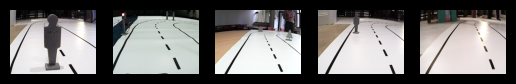

In [153]:
f, axarr = plt.subplots(1,5)

i = 0
for image, angle in dataset:
    print('Image shape: ', np.shape(image))
    tf.print('Angle: ', angle)
    axarr[i].imshow(image)
    axarr[i].axis('off')
    i = i+1

In [157]:
rnd = np.random.RandomState(seed=None)

IMG_HEIGHT = 224
IMG_WIDTH = 224
BUFFER_SIZE = 1000
BATCH_SIZE = 24

training_ds = ds.map(
    lambda image, angle: (tf.image.decode_image(tf.io.read_file(image)), angle)
).map( # random horizontal fip
      lambda image, angle: (tf.image.random_flip_left_right(image, seed=rnd.seed(1234)), angle)
).map( # random translation
      lambda image, angle: (tfa.image.translate(image, tf.random.normal(shape=[2], seed=1234)), angle)
).cache( # cache images
).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

### Reading images

In [59]:
# read image
image = cv2.imread(imagesLst[28])
# convert to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# convert to tensor
image_to_tensor = tf.convert_to_tensor(image, dtype=tf.float32)

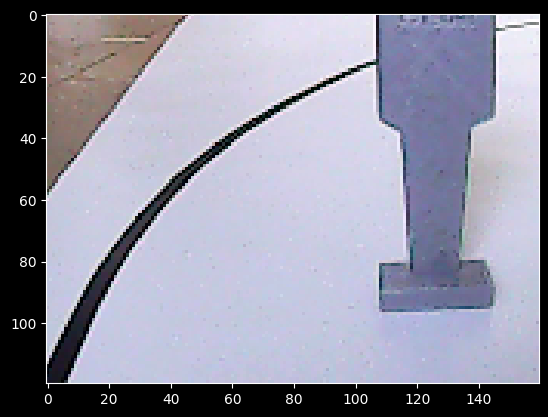

In [61]:
# center crop an image
cropped = tf.image.central_crop(image, central_fraction=0.5)
plt.imshow(cropped)

In [54]:
# Image augmentation
class AugmentImage:
    def __init__(self, imgPath):
        self.imgPath = imgPath

    @tf.function
    def _up_down_flip(image, label):
        image = tf.image.flip_up_down(image)
        label = tf.image.flip_up_down(label)
        return image, label

    @tf.function
    def _left_right_flip(image, angle):
        image = tf.image.flip_left_right(image)
        angle = tf.image.flip_up_down(angle)
        return image, angle

    @tf.function
    def _rotate(image):
        random_angle = tf.random.stateless_uniform(shape=[], minval=-45, maxval=45, dtype=tf.int32)
        image = tf.image.rot90(image, random_angle)
        return image

    @tf.function
    def _hue(image):
        rand_value = np.random.uniform(-1,1)
        image = tf.image.adjust_hue(image, rand_value)
        return image

    @tf.function
    def _brightness(image):
        rand_value = np.random.uniform(-0.08,0.25)
        image = tf.image.adjust_brightness(image, rand_value)
        return image

    @tf.function
    def _saturation(image):
        rand_value = np.random.uniform(1, 5)
        image = tf.image.adjust_saturation(image, rand_value)
        return image

    @tf.function
    def _contrast(image):
        rand_value = np.random.uniform(1, 3)
        image = tf.image.adjust_contrast(image, rand_value)
        return image

In [ ]:
# Generate images on the fly while training model
def img_generator(imgLst, anglesLst, batchSize, use_augmentation: bool = True):
    while True:
        imgBatch = []
        anglesBatch = []

        for i in range(batchSize):


In [52]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

IMG_HEIGHT = 224
IMG_WIDTH = 224
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

def create_model(input_shape):
    input = Input(shape=input_shape)

    core = keras.applications.MobileNet(input_tensor=input, include_top=False, pooling='avg')

    output = Dense()(core.output)

    return Model(input, output)

# NOTE: we might need more complex model suggested by NVIDIA
# ref: https://towardsdatascience.com/teaching-cars-to-drive-using-deep-learning-steering-angle-prediction-5773154608f2

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=)
loss = keras.losses.MeanSquaredError()

In [18]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMG_SIZE, IMG_SIZE),
    layers.Rescaling(1./255)
])

In [19]:
plt.imshow(resize_and_rescale(images[1]))

TypeError: Exception encountered when calling layer 'resizing' (type Resizing).

Cannot convert '/Users/rahuln/PycharmProjects/PiCardo/machine-learning-in-science-ii-2023/training_data/9994.png' to EagerTensor of dtype float

Call arguments received by layer 'resizing' (type Resizing):
  • inputs='/Users/rahuln/PycharmProjects/PiCardo/machine-learning-in-science-ii-2023/training_data/9994.png'

### Object detection
YOLO (You Only Look Once) implementaion

In [ ]:
# Importig dependencies
import shutil

In [ ]:
#filepath = 'Self Driving Car.v3-fixed-small.tensorflow/export/_annotations.csv'
classes = ['Object', 'Pedestrian', 'Tree', 'TrafficLight-Red', 'TrafficLight-Green', 'Turn-Left', 'Turn-Right']
data_path = '/Users/rahuln/PycharmProjects/picardo/machine-learning-in-science-ii-2023/'
src_path = os.path.join(data_path, 'training_data')
dst_path = os.path.join(data_path, 'sub_training_data')
annotations_path = os.path.join(data_path, 'annotations')

In [ ]:
# Check if images path and annotations path exists
def checkPath(path):
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}

checkPath(src_path)
checkPath(dst_path)
checkPath(annotations_path)


In [ ]:
# Choose random images from images path
from typing import List
from typing import Any

def getRandomImgs(path) -> List[Any]:
    n_imgs = 100

    imgs = [img for img in os.listdir(path)]
    return list(np.random.choice(imgs, n_imgs))

rand_imgs = getRandomImgs(src_path)

for img in rand_imgs:
    try:
        shutil.copy(os.path.join(src_path, img), dst_path)
    except shutil.SameFileError:
        print('Source and destination are same!')
    except IOError:
        print('Error occurred while copying file!')

In [ ]:
# Let's annotate images using labelImg module
labelImg_path = 'labelImg'
classes_path = os.path.join(annotations_path, 'classes.txt')
git_url = 'https://github.com/heartexlabs/labelImg.git'

if not os.path.exists(labelImg_path):
    if os.name == 'posix':
        !mkdir -p {labelImg_path}
        !git clone {git_url} {labelImg_path} # cloning from git url

#calling module
if os.name == 'posix':
    !cd {labelImg_path} && make qt5py3
    !cd {labelImg_path} && python labelImg.py {dst_path} {classes_path}

In [ ]:
df = pd.read_csv(os.path.join(data_path, 'training_norm.csv'))

In [ ]:
df.head()

In [ ]:
# train test split of dataset
rng = np.random.RandomState(seed=1234)

train_data = df['image_id'].sample(frac=0.7, random_state=rng)
test_data = df.loc[~df.index.isin(train_data.index)]

In [ ]:
train_data = train_data.to_numpy()

In [ ]:
train_data[:5]

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Input, LeakyReLU

In [ ]:
# Define YOLOv4 model

def yolov4():
    pass